In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from skimage import io
from skimage.color import rgb2gray
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
58804,00014553_001.png,No Finding,1,14553,7,F,PA,2106,2289,0.143,0.143,NaN
80152,00019700_004.png,Mass,4,19700,11,M,PA,2992,2991,0.143,0.143,NaN
72468,00017852_024.png,No Finding,24,17852,32,F,AP,2500,2048,0.168,0.168,NaN


In [3]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2556,00012863_023.png,Infiltration,23,12863,040Y,F,AP,2500,2048,0.168,0.168
577,00003006_000.png,No Finding,0,3006,034Y,F,PA,2500,2048,0.171,0.171
576,00002986_002.png,No Finding,2,2986,051Y,F,PA,2992,2991,0.143,0.143


In [4]:
## EDA
# Split Finding Labels column and turn each label into a column with a binary Flag
labels = np.unique(list(chain(*all_xray_df["Finding Labels"].map(lambda x: x.split("|")))))
print("Labels: ", labels)
for label in labels:
    all_xray_df[label] = all_xray_df["Finding Labels"].map(lambda x: 1 if label in x else 0)
    
all_xray_df.sample(3)

Labels:  ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
106485,00028696_001.png,Nodule,1,28696,17,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,1,0,0,0
79436,00019513_000.png,No Finding,0,19513,55,F,PA,2512,3056,0.139,...,0,0,0,0,0,1,0,0,0,0
99315,00026263_014.png,Effusion,14,26263,38,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0


### Population Caracteristics

#### Age

In [5]:
df_length = len(all_xray_df)
df_older100 = len(all_xray_df["Patient Age"][all_xray_df["Patient Age"] > 100])
print("Age Count\n", all_xray_df["Patient Age"][all_xray_df["Patient Age"] > 100].value_counts())
print("\nData frame length: ", df_length)
print("Number of patients older than 100 years old: ", df_older100)
print("Patients older than 100 years old: %0.2f %%"%(df_older100 / df_length * 100))

Age Count
 412    3
148    2
155    2
414    1
413    1
411    1
154    1
153    1
152    1
151    1
150    1
149    1
Name: Patient Age, dtype: int64

Data frame length:  112120
Number of patients older than 100 years old:  16
Patients older than 100 years old: 0.01 %


There are patients with ages older than 100 years old in the data set. Each year bigger than 100 appears only once in the data set most of the time, so they are likely input errors and will be ignored for the age distribution.

Minimum age:  1
Maximum age:  95


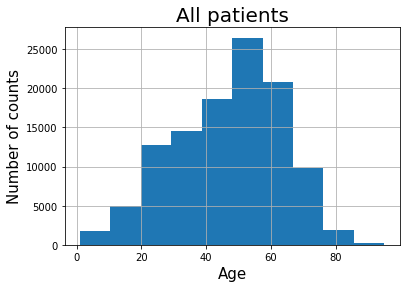

In [6]:
filt1 = (all_xray_df["Patient Age"] < 100)

age_pop = all_xray_df["Patient Age"][filt1]
_ = age_pop.hist()
_ = plt.xlabel("Age", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("All patients", size=20)

print("Minimum age: ", min(age_pop))
print("Maximum age: ", max(age_pop))

Minimum age:  2
Maximum age:  90


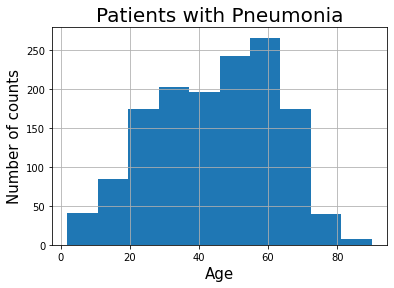

In [7]:
filt2 = (all_xray_df.Pneumonia == 1)

age_pop = all_xray_df["Patient Age"][filt1 & filt2]
_ = age_pop.hist()
_ = plt.xlabel("Age", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("Patients with Pneumonia", size=20)

print("Minimum age: ", min(age_pop))
print("Maximum age: ", max(age_pop))

The data set population includes individuals from 1 to 95 years old with a peak around 50. The population with penumonia includes individuals from 2 to 90 years old with a peak around 60.

#### Sex

Males: 56.49 %
Females: 43.51 %


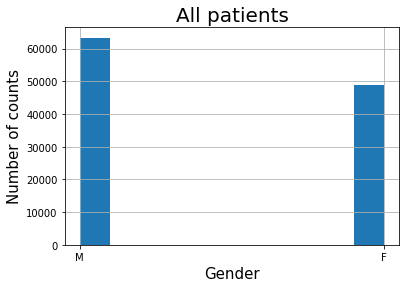

In [8]:
sex_pop = all_xray_df["Patient Gender"]
_ = sex_pop.hist()
_ = plt.xlabel("Gender", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("All patients", size=20)

numM = sex_pop.value_counts()[0]
numF = sex_pop.value_counts()[1]
print("Males: %.2f %%"%(100 * numM / len(sex_pop)))
print("Females: %.2f %%"%(100 * numF / len(sex_pop)))

Males: 58.56 %
Females: 41.44 %


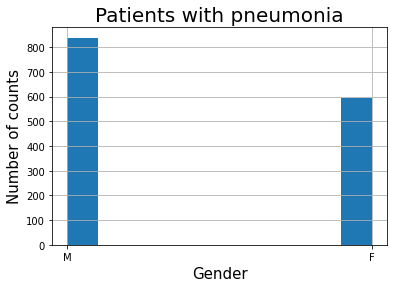

In [9]:
sex_pop = all_xray_df["Patient Gender"][filt2]
_ = sex_pop.hist()
_ = plt.xlabel("Gender", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("Patients with pneumonia", size=20)

numM = sex_pop.value_counts()[0]
numF = sex_pop.value_counts()[1]
print("Males: %.2f %%"%(100 * numM / len(sex_pop)))
print("Females: %.2f %%"%(100 * numF / len(sex_pop)))

Considering population gender, males are dominant for the total population and the population with pneumonia.

#### X-ray view position

PA: 60.03 %
AP: 39.97 %


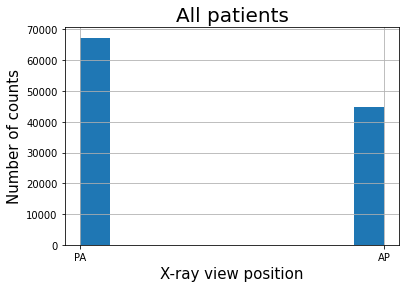

In [10]:
position_pop = all_xray_df["View Position"]
_ = position_pop.hist()
_ = plt.xlabel("X-ray view position", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("All patients", size=20)

numPA = position_pop.value_counts()[0]
numAP = position_pop.value_counts()[1]
print("PA: %.2f %%"%(100 * numPA / len(position_pop)))
print("AP: %.2f %%"%(100 * numAP / len(position_pop)))

PA: 55.97 %
AP: 44.03 %


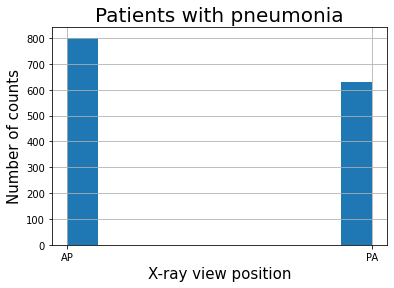

In [11]:
position_pop = all_xray_df["View Position"][filt2]
_ = position_pop.hist()
_ = plt.xlabel("X-ray view position", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("Patients with pneumonia", size=20)

numPA = position_pop.value_counts()[0]
numAP = position_pop.value_counts()[1]
print("PA: %.2f %%"%(100 * numPA / len(position_pop)))
print("AP: %.2f %%"%(100 * numAP / len(position_pop)))

The PA position is predominant for all patients as well as for patients with pneumonia.

#### Presence of pneumonia

Absence of pneumonia: 98.72 %
Presence of pneumonia: 1.28 %


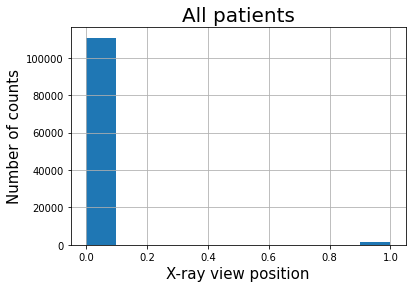

In [12]:
pneumonia_pop = all_xray_df.Pneumonia
_ = pneumonia_pop.hist()
_ = plt.xlabel("X-ray view position", size=15)
_ = plt.ylabel("Number of counts", size=15)
_ = plt.title("All patients", size=20)

num0 = pneumonia_pop.value_counts()[0]
num1 = pneumonia_pop.value_counts()[1]
print("Absence of pneumonia: %.2f %%"%(100 * num0 / len(pneumonia_pop)))
print("Presence of pneumonia: %.2f %%"%(100 * num1 / len(pneumonia_pop)))

Only 1.28% of the analyzed population has pneumonia.

### Comorbidities with pneumonia

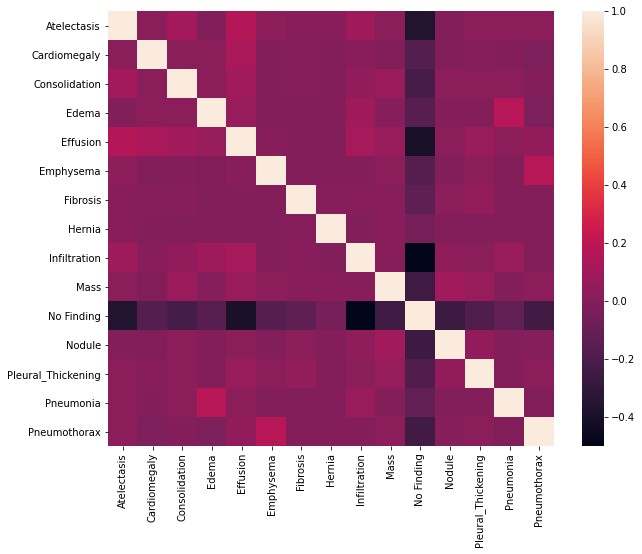

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Atelectasis,1.000000,0.015819,0.108943,-0.003397,0.172445,0.032599,0.011130,0.010830,0.093131,0.018953,-0.366126,-0.007967,0.025202,0.029911,0.031422
Cardiomegaly,0.015819,1.000000,0.015360,0.028318,0.130094,-0.007090,0.004837,0.001762,0.014189,-0.010682,-0.172067,-0.012123,0.009121,0.002848,-0.022248
Consolidation,0.108943,0.015360,1.000000,0.020822,0.101130,-0.000521,0.003236,-0.005413,0.045926,0.074573,-0.225058,0.031819,0.028733,0.025235,0.000485
Edema,-0.003397,0.028318,0.020822,1.000000,0.062092,-0.009204,-0.013243,-0.002326,0.094208,0.002910,-0.156386,0.000261,-0.002032,0.173996,-0.022487
Effusion,0.172445,0.130094,0.101130,0.062092,1.000000,0.011198,-0.002776,-0.003656,0.118136,0.070710,-0.396464,0.019114,0.072009,0.024322,0.047571
Emphysema,0.032599,-0.007090,-0.000521,-0.009204,0.011198,1.000000,-0.000908,-0.001466,0.000406,0.023213,-0.163617,-0.007062,0.026408,-0.004888,0.178175
Fibrosis,0.011130,0.004837,0.003236,-0.013243,-0.002776,-0.000908,1.000000,0.007478,0.008794,0.009959,-0.133433,0.022478,0.053578,-0.006867,0.000094
Hernia,0.010830,0.001762,-0.005413,-0.002326,-0.003656,-0.001466,0.007478,1.000000,-0.003780,0.011927,-0.048640,-0.002422,0.001330,0.000182,-0.001621
Infiltration,0.093131,0.014189,0.045926,0.094208,0.118136,0.000406,0.008794,-0.003780,1.000000,0.014047,-0.501556,0.042749,0.020381,0.073020,0.000576
Mass,0.018953,-0.010682,0.074573,0.002910,0.070710,0.023213,0.009959,0.011927,0.014047,1.000000,-0.251814,0.101253,0.065388,-0.001005,0.029940


In [13]:
corr_matrix = all_xray_df.iloc[:,-len(labels):].corr() # correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix)
plt.show()
corr_matrix

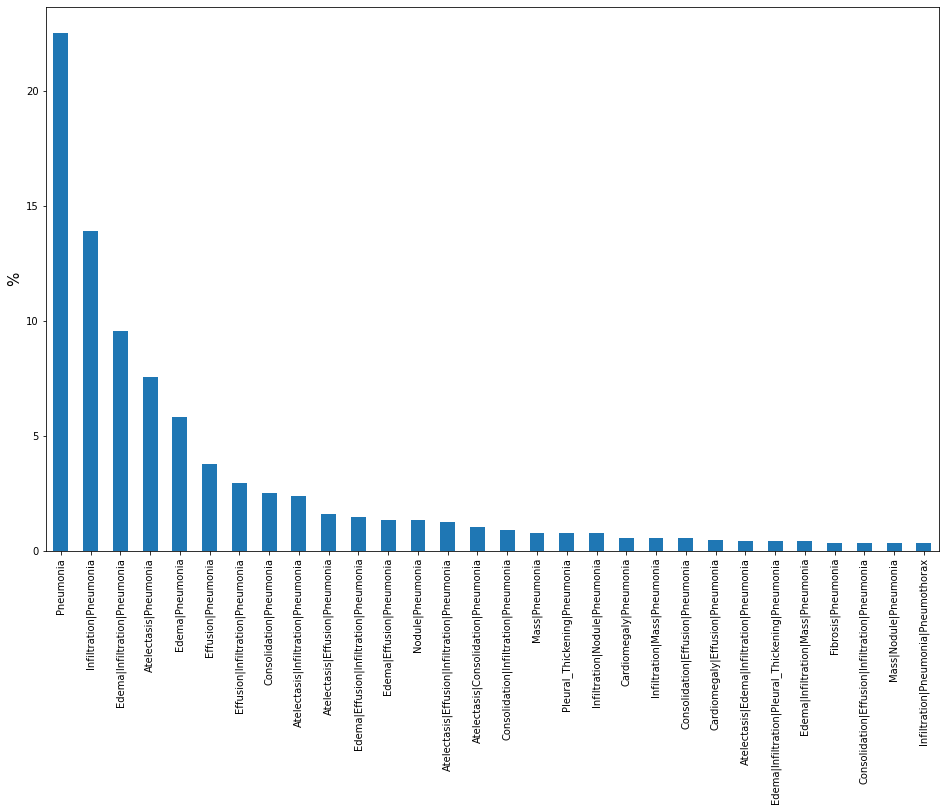

In [14]:
plt.figure(figsize=(16, 10))
comorbidities_numbers = all_xray_df[filt2]['Finding Labels'].value_counts()
_ = (comorbidities_numbers / len(all_xray_df[filt2]) * 100)[:30].plot(kind='bar')
_ = plt.ylabel('%', size=15)

According to the correlation matrix, pneumonia's most common comorbidities are edema and infiltration. This confirmed by the histogram above, which also shows that in more than 75% of cases pneumonia is concurrent with another disease. The most common diseases with pneumonia are infiltration, edema, atelectasis and effusion. Only in around 22.5% of positive cases, pneumonia is found alone.

### Number of diseases per patient

Total patients:  112120
Healthy patients: 53.84%

Patients with disease(s): 46.16%
Among them:
Number Percentage
 1    59.821480
2    27.639638
3     9.381943
4     2.409243
5     0.581541
6     0.129446
7     0.030912
8     0.001932
9     0.003864
dtype: float64


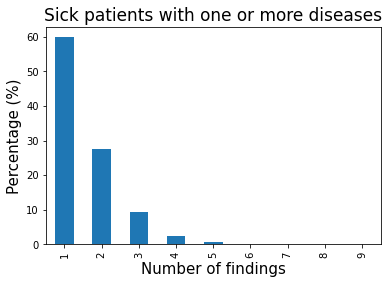

In [15]:
filt3 = (all_xray_df["No Finding"] == 0)
total_patients = len(all_xray_df)
findings = len(all_xray_df[filt3])
no_findings = all_xray_df["No Finding"].sum()

percNumDiseases = all_xray_df[filt3].iloc[:, -len(labels):].sum(axis=1).value_counts(normalize=True, sort=False) * 100

_ = percNumDiseases.plot(kind='bar')
_ = plt.xlabel("Number of findings", size=15)
_ = plt.ylabel("Percentage (%)", size = 15)
_ = plt.title("Sick patients with one or more diseases", size=17)

print("Total patients: ", total_patients)
print("Healthy patients: %.2f%%"%(no_findings / total_patients * 100))
print("\nPatients with disease(s): %0.2f%%"%(findings / total_patients * 100))
print("Among them:\nNumber Percentage\n", percNumDiseases)

46.16% of the patients have one or more diseases. Among them, almost 60% have only one disease, around 28% have two diseases and around 9% three diseases. Combined, patients with 4 or more diseases represent around 3% of the patients with a condition.

### Pixel level assesment of images

In [16]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5262,00028253_007.png,No Finding,7,28253,021Y,F,PA,2786,2991,0.143,0.143
4378,00021610_034.png,No Finding,34,21610,046Y,M,AP,3056,2544,0.139,0.139
1601,00008322_000.png,No Finding,0,8322,059Y,F,PA,2500,2048,0.168,0.168


In [17]:
# Split Finding Labels column and turn each label into a column with a binary Flag
labels = np.unique(list(chain(*sample_df["Finding Labels"].map(lambda x: x.split("|")))))
print("Labels: ", labels)
for label in labels:
    sample_df[label] = sample_df["Finding Labels"].map(lambda x: 1 if label in x else 0)
    
sample_df.sample(3)

Labels:  ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3367,00016607_018.png,No Finding,18,16607,064Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
5195,00027726_057.png,Infiltration,57,27726,058Y,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,0,0
1401,00007286_013.png,Infiltration,13,7286,052Y,M,AP,2500,2048,0.171,...,0,0,0,1,0,0,0,0,0,0


In [18]:
def find_path(name, path):
    '''
    Function to find path of image name.
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
        
def total_pixels(df, disease):
    '''
    Returns all the pixels from all the images related to a disease(s).
    '''
    dis_pix_values = []
    for image in df["Image Index"][df[disease] == 1]:
        # find image location
        path = find_path(image, "./data")
        # read image and calculate mean and std
        image = io.imread(path)
        # if image is not gray, turn it gray
        if (len(image.shape) != 2):
            image = rgb2gray(image)
            
        mean = np.mean(image)
        std = np.std(image)
        # normalize pixel values
        pix_values = (image.ravel() - mean) / std
        # add pixels to total pixels list
        dis_pix_values.extend(pix_values)
        
    return np.array(dis_pix_values)

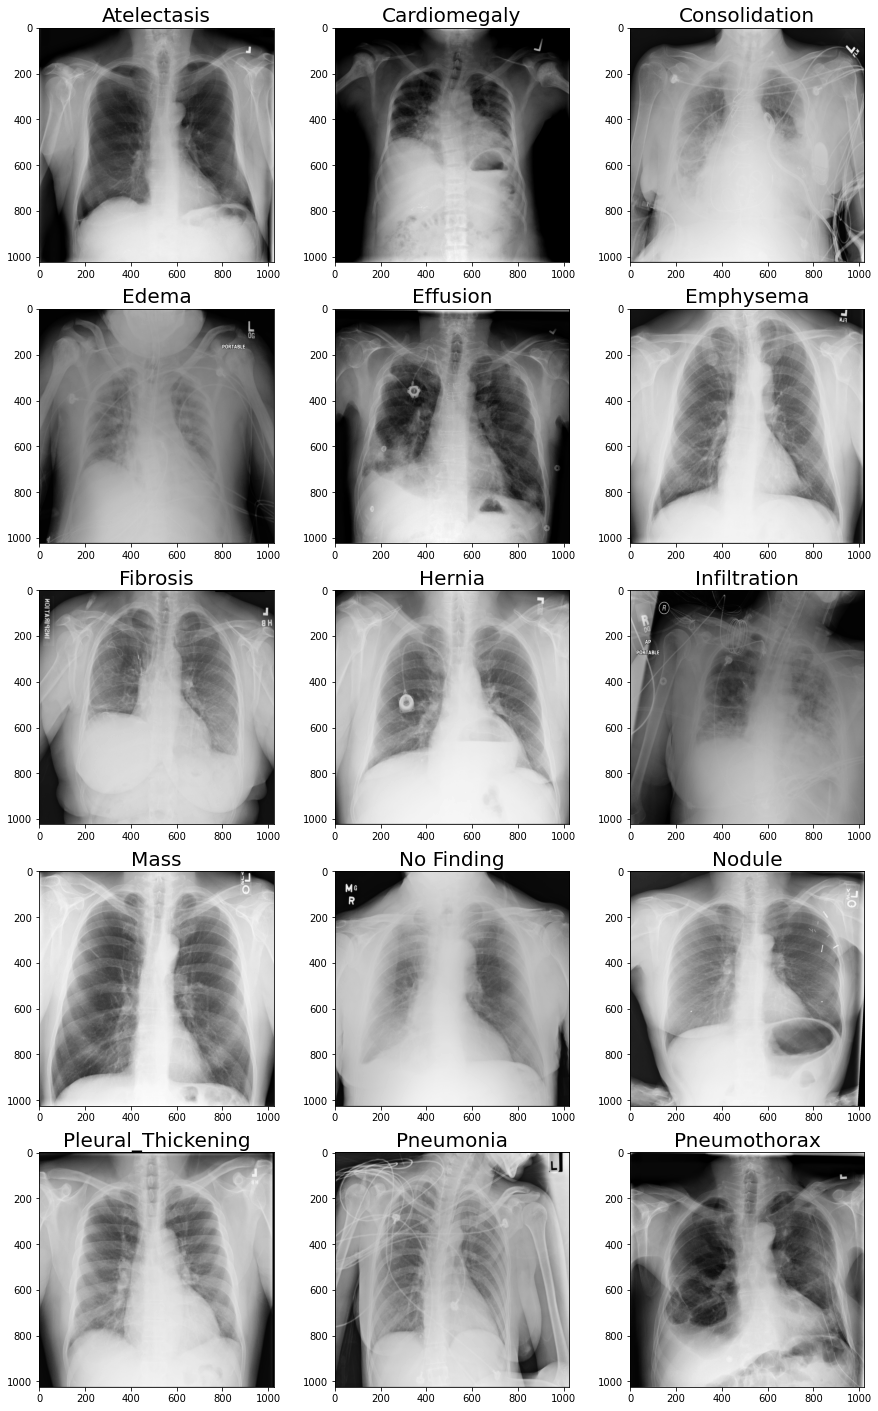

In [19]:
# Plot images for each disease when they are presented individually
filt4 = sample_df.iloc[:, -len(labels):].sum(axis=1) == 1
plt.figure(figsize=(15,25))
for i, label in enumerate(labels):
    for image_name in sample_df["Image Index"][(sample_df[label] == 1) & filt4]:
        # find image location
        path = find_path(image_name, "./data")
        # read image and calculate mean and std
        image = io.imread(path)
        plt.subplot(5,3,i+1)
        plt.imshow(image, 'gray')
        plt.title(label, size=20)
        break

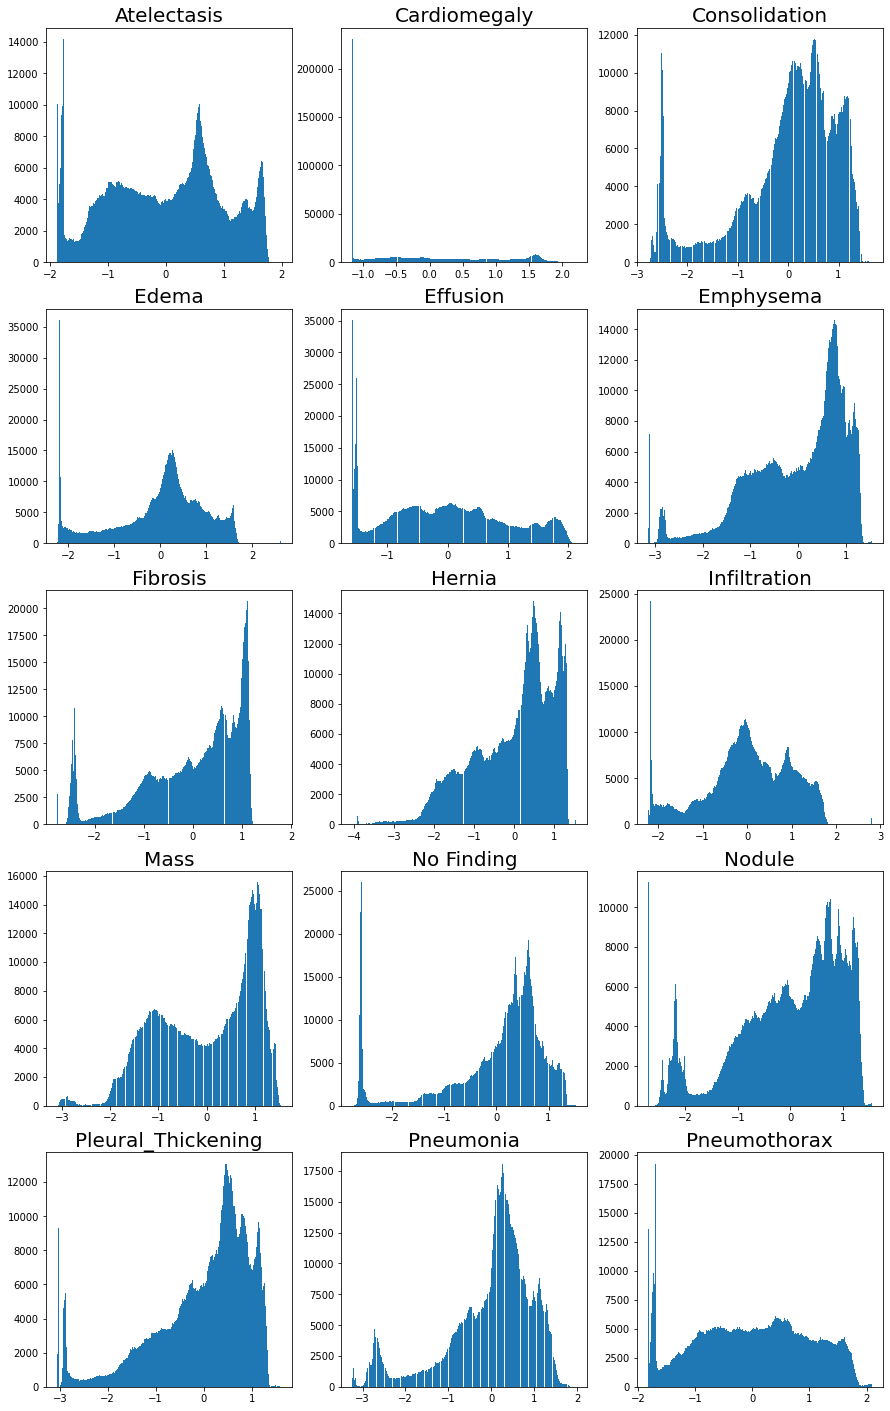

In [20]:
# Histograms for the images shown above
# Plot images for each disease when they are presented individually
filt4 = sample_df.iloc[:, -len(labels):].sum(axis=1) == 1
plt.figure(figsize=(15,25))
for i, label in enumerate(labels):
    for image_name in sample_df["Image Index"][(sample_df[label] == 1) & filt4]:
        # find image location
        path = find_path(image_name, "./data")
        # read image and calculate mean and std
        image = io.imread(path)
        image = (image - np.mean(image)) / np.std(image)
        plt.subplot(5,3,i+1)
        plt.hist(image.ravel(), bins=256)
        plt.title(label, size=20)
        break

The histogram of a pneumonia X-ray presents a pic whithin a half standard deviation from its mean value but edema images have the same property. Given that the images have a lot of dark and bright pixels that are not related to a disease finding, it would be worth to check the histograms of the regions where the condition is found in an image. 

In [21]:
# Open BBox_List_2017.csv for region's of interest
bbox_df = pd.read_csv("./data/BBox_List_2017.csv")
bbox_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [22]:
# inner join of bbox_df with sample_df
join_df = pd.DataFrame(bbox_df[bbox_df.columns[:-3]]).merge(sample_df, on="Image Index")
join_df.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Finding Labels,Follow-up #,Patient ID,Patient Age,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00022883_002.png,Atelectasis,114.440678,511.222607,733.288136,108.474576,Atelectasis|Effusion|Infiltration,2,22883,067Y,...,0,0,0,1,0,0,0,0,0,0
1,00030434_000.png,Atelectasis,667.661017,645.731081,75.932203,239.728814,Atelectasis,0,30434,053Y,...,0,0,0,0,0,0,0,0,0,0
2,00020408_037.png,Atelectasis,190.372881,632.714132,227.796610,160.542373,Atelectasis|Effusion,37,20408,045Y,...,0,0,0,0,0,0,0,0,0,0
3,00021495_005.png,Atelectasis,541.830508,640.307352,299.389831,265.762712,Atelectasis|Consolidation|Effusion|Emphysema|N...,5,21495,022Y,...,1,0,0,0,0,0,1,0,0,1
4,00010481_021.png,Atelectasis,763.118644,551.864407,160.542373,68.338983,Atelectasis,21,10481,044Y,...,0,0,0,0,0,0,0,0,0,0


In [23]:
labels_join = join_df["Finding Label"].unique()
labels_join

array(['Atelectasis', 'Cardiomegaly', 'Pneumonia', 'Effusion',
       'Infiltrate', 'Mass', 'Nodule', 'Pneumothorax'], dtype=object)

Not all the labels are found in the bbox_df, but there are enough to see how a pneumonia image compares to other diseases.

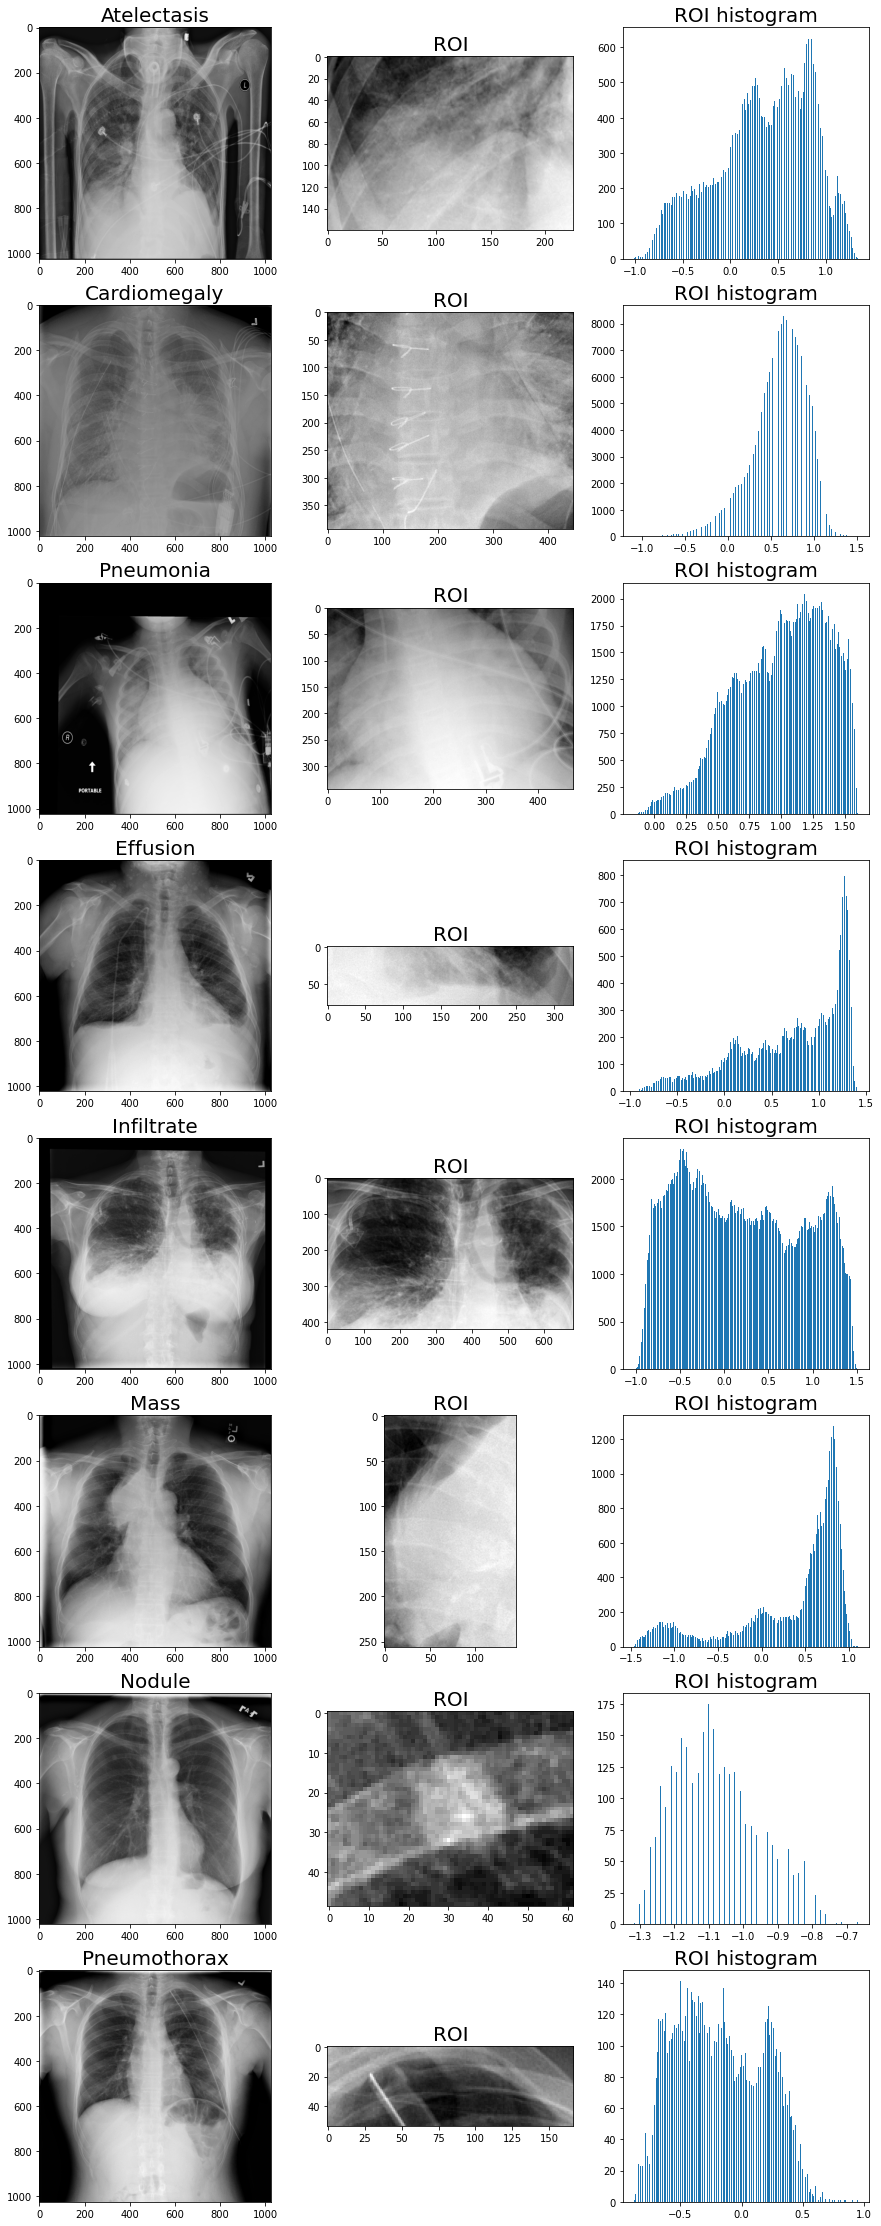

In [24]:
# Check ROIs
plt.figure(figsize=(15,40))
for i, label in enumerate(labels_join):
    for image_name in join_df["Image Index"][(join_df["Finding Label"] == label) & filt4]:
        # find image location
        path = find_path(image_name, "./data")
        # read image and calculate mean and std
        x, y, w, h = (join_df[join_df["Image Index"] == image_name].iloc[0, 2:6]).astype('int')
        image = io.imread(path)
        image = (image - np.mean(image)) / np.std(image)
        # image
        plt.subplot(8,3,3*i+1)
        plt.imshow(image, 'gray')
        plt.title(label, size=20)
        # ROI
        image = image[y:y+h, x:x+w]
        plt.subplot(8,3,3*i+2)
        plt.imshow(image, 'gray')
        plt.title("ROI" , size=20)
        # hist
        plt.subplot(8,3,3*i+3)
        plt.hist(image.ravel(), bins=256)
        plt.title('ROI histogram', size=20)
        break

Most of the diseases appear to present peaks above average except for pneumothorax and nodules, which have broad peaks (~1 standard deviation) below hiistogram average. In the case of pneumonia, it seems that a majority of pixels in the area of interest are above average.

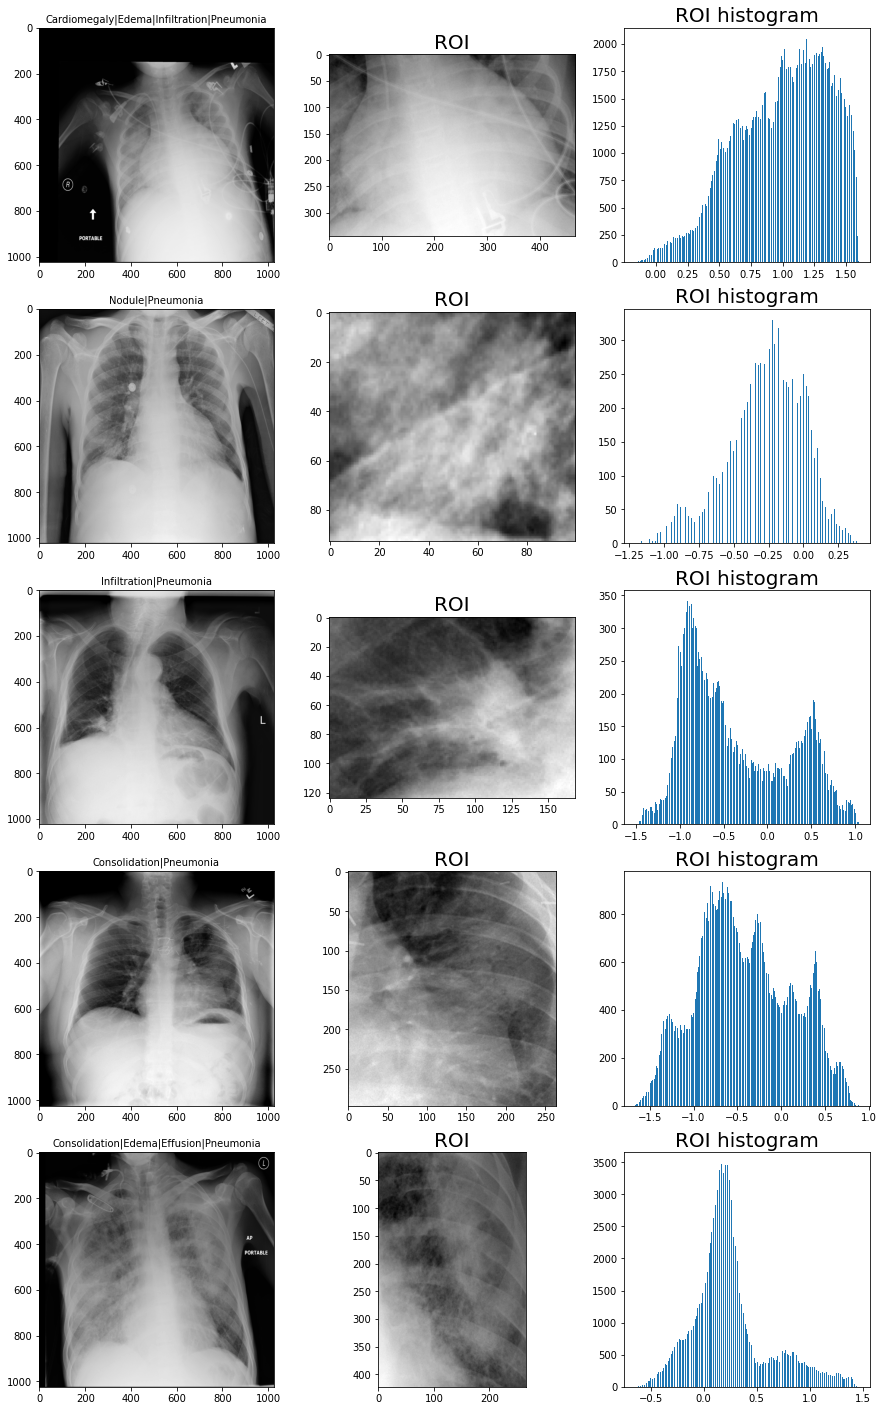

In [25]:
filta = (join_df["Finding Label"]=='Pneumonia')
filtb = (join_df.Pneumonia==1)
# Other diseases with pneumonia in the same image
others_lab = join_df["Finding Labels"][filta & filtb].unique()
rows = len(others_lab)
# plot histograms of ROIs
plt.figure(figsize=(15,25))
for i, label in enumerate(others_lab):
    for image_name in join_df["Image Index"][filta & filtb & (join_df["Finding Labels"]==label)]:
        # find image location
        path = find_path(image_name, "./data")
        # read image and calculate mean and std
        x, y, w, h = (join_df[join_df["Image Index"] == image_name].iloc[0, 2:6]).astype('int')
        image = io.imread(path)
        image = (image - np.mean(image)) / np.std(image)
        # image
        plt.subplot(rows,3,3*i+1)
        plt.imshow(image, 'gray')
        plt.title(label, size=10)
        # ROI
        image = image[y:y+h, x:x+w]
        plt.subplot(rows,3,3*i+2)
        plt.imshow(image, 'gray')
        plt.title("ROI" , size=20)
        # hist
        plt.subplot(rows,3,3*i+3)
        plt.hist(image.ravel(), bins=256)
        plt.title('ROI histogram', size=20)
        break

When other medical condition are present, it appears that for 2 cases the histogram has a broad peak of ~1 standard deviation: Cardiomegaly|Edema|Infiltration|Pneumonia and Consolidation|Pneumonia. For Nodule|Pneumonia and Consolidation|Edema|Effusion|Pneumonia, the peak is whithin one standard deviation. And for Consolidation|Pneumonia two peaks are present, one above histogram average and another below average. But as an overall trend, by looking also to the previous histograms, it seems that pneumonia is characterized by a peak above average whithin half to one standard deviation 

## Conclusion

It appears that pneumonia is not a prevealent condition in the present data set, only ~1.28% of the analyzed population. Patients with pneumonia are present at all age between 2 and 90 years old but with a higher predominance at 60 years old. 

While 75% of pneumonia cases are concurrent with another diseases, pneumonia's most common comorbidities are edema and infiltration. In only ~22.5% of positive cases, pneumonia is found alone. Of the positive pneumonia cases, the majority are males with 58.56% and females represent only 41.44% of cases.

From the pixel analysis point of view, it appears that histgrams of pneumonia regions present a peak above average whithin 0.5 to 1 standard deviation. However, this characterization tend to disappear if more than 2 conditions are concurrent with pneumonia.